In [1]:
# import statements

from torch import nn
import torch
import gym
from collections import deque
import itertools
import numpy as np
import random
import pdb
from matplotlib import pyplot as plt 

In [2]:
# set random seed
random.seed(0)

In [3]:
# hyperparameters

GAMMA = 0.99
NUM_NODES = 24
BATCH_SIZE = 32
BUFFER_SIZE = 50000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQ = 1000
LEARNING_RATE = 5e-4
MAX_STEPS = 200000

# Regularization Coefficient
REGULARIZATION_COEFFICIENT = 0.1

### Custom Loss Functions

In [4]:
phi_matrix = []
observations_t = None
new_observations_t = None

In [5]:
# default loss function - mean squared error

def default_loss_mse(y_true, y_pred):
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    return loss

In [6]:
# custom loss function - implements explicit DR3 regularizer

# add dot product between each state action and subsequent one’s feature vector to loss
def dr3(y_true, y_pred):
    
    global observations_t, new_observations_t
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    curr_states = online_net.get_phi(observations_t)
    next_states = online_net.get_phi(new_observations_t)
    
    # pdb.set_trace()
    
    loss += REGULARIZATION_COEFFICIENT * torch.sum(torch.sum(curr_states * next_states, axis=1)) / BATCH_SIZE
    
    return loss

In [7]:
# custom loss function - random dot product from phi matrix

# randomly sample two vectors from the phi matrix and add dot product of those vectors to loss
def random_dot(y_true, y_pred):

    global phi_matrix
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    # Explicit Regularization
    if ((phi_matrix is not None) and (len(phi_matrix) > 1)):
        
        v1 = phi_matrix[random.randrange(len(phi_matrix))]
        v2 = phi_matrix[random.randrange(len(phi_matrix))]
        
        # pdb.set_trace()
        
        loss += REGULARIZATION_COEFFICIENT * torch.dot(torch.tensor(v1), torch.tensor(v2))
        
    return loss

In [8]:
# custom loss function - implements regulizer based on min/max singular values in phi matrix

# add difference between max entry in phi matrix ** 2 and min entry in phi matrix ** 2 to loss
def phi_penalty(y_true, y_pred):
    
    global phi_matrix
    
    loss = torch.mean(torch.square(y_true-y_pred))
    
    # Explicit Regularization
    if ((phi_matrix is not None) and (len(phi_matrix) > 0)):
        
        minimum = min([min(value) for value in phi_matrix])
        maximum = max([max(value) for value in phi_matrix])
        
        # pdb.set_trace()
        
        loss += REGULARIZATION_COEFFICIENT * torch.sub(maximum**2, minimum**2)
            
    return loss

### Network Class

In [9]:
# create network class

class Network(nn.Module):
    
    def __init__(self, env):
        super().__init__()        
        in_features = int(np.prod(env.observation_space.shape))     
        # Neural Network
        self.layer1 = nn.Linear(in_features, NUM_NODES)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.ReLU()
        self.layer4 = nn.Linear(NUM_NODES, env.action_space.n)
    
    def forward(self, x):
        return self.layer4(self.layer3(self.layer2(self.layer1(x))))
    
    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))
        
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        
        return action
    
    def get_phi(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

### Create OpenAI Gym Environment

In [10]:
# create environment

env = gym.make('CartPole-v0')

replay_buffer = deque(maxlen=BUFFER_SIZE)
reward_buffer = deque([0.0], maxlen=100)

all_ranks = []
last_100_ranks = deque([], maxlen=100)
all_rewards = []

episode_reward = 0.0

online_net = Network(env)
target_net = Network(env)

target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.Adam(online_net.parameters(), lr=LEARNING_RATE)

obs = env.reset()
for _ in range(MIN_REPLAY_SIZE):
    
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    transition = (obs, action, reward, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs
    
    if done:
        obs = env.reset() 

### Choose Loss Function

In [11]:
# default_loss_mse
# dr3
# random_dot
# phi_penalty

loss_function = dr3

### Training

In [12]:
# training

obs = env.reset()

for step in range(1, MAX_STEPS+1):
    
    epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])
    
    rng = random.random()
    if rng <= epsilon:
        action = env.action_space.sample()
    else:
        action = online_net.act(obs)
    
    new_obs, reward, done, _ = env.step(action)
    transition = (obs, action, reward, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs
    
    episode_reward += reward
    
    if done:
        obs = env.reset()
        reward_buffer.append(episode_reward)
        all_rewards.append(episode_reward)
        episode_reward = 0.0
        
    # Start Gradient Step   
    transitions = random.sample(replay_buffer, BATCH_SIZE)
    
    observations = np.asarray([t[0] for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rewards = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_observations = np.asarray([t[4] for t in transitions])
    
    observations_t = torch.as_tensor(observations, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_observations_t = torch.as_tensor(new_observations, dtype=torch.float32)
    
    # Compute Targets
    target_q_values = target_net(new_observations_t)
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    
    targets = rewards_t + GAMMA * (1 - dones_t) * max_target_q_values
    
    # Compute Loss
    q_values = online_net(observations_t)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
    loss = loss_function(action_q_values, targets)
    
    # Gradient Descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute Phi Matrix
    phi_matrix = []
    phi_matrix = online_net.get_phi(observations_t)
    phi_matrix = phi_matrix.cpu().detach().numpy()
    rank = np.linalg.matrix_rank(phi_matrix)
    all_ranks.append(rank)
    last_100_ranks.append(rank)
    
    # Update Target Network
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(online_net.state_dict())
        
    # Logging
    PRINT_LOG = False
    if PRINT_LOG and step % 1000 == 0:
        print()
        print("Step:", step)
        print("Average Reward:", np.mean(reward_buffer))
        print("Average Rank:", np.mean(last_100_ranks))

### Rank Collapse Statistics

In [13]:
# max, min, and range rank

starting_rank = np.mean(all_ranks[:10])
final_rank = np.mean(all_ranks[-20:])
print(starting_rank, final_rank, starting_rank-final_rank)

19.4 9.45 9.95


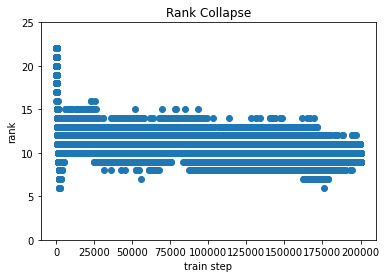

In [14]:
plt.scatter(list(range(len(all_ranks))), all_ranks)

plt.ylim(0, 25) # set range for y axis
plt.ylabel('rank') # set the label for y axis
plt.xlabel('train step') # set the label for x-axis
plt.title("Rank Collapse") # set the title of the graph

plt.show() # display the graph

In [15]:
# max reward

print(np.mean(all_rewards[-10:]))

200.0


plt.scatter(list(range(len(all_rewards))), all_rewards)

plt.ylim(0, 200) # set range for y axis
plt.ylabel('reward') # set the label for y axis
plt.xlabel('episode') # set the label for x-axis
plt.title("Episode Reward") # set the title of the graph

plt.show() # display the graph